<a href="https://colab.research.google.com/github/solobala/DLL30/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22DLL30_DZ9_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание по теме «Рекуррентные сети 4 Механизм внимания»

Преподаватель: Даниил Корбут, Алексей Миронов, Татьяна Булгакова, Светлана Медведева, Артём Качалкин, Никита Селин

Возьмите англо-русскую пару фраз (www.manythings.org....org/anki/)

1. Обучите на них seq2seq with attention:
  *  на основе скалярного произведения
  *  на основе mlp

2. Оцените полученное качество


# Импорт библиотек

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [2]:
from google.colab import drive
from google.colab import files

In [3]:
from io import open
import unicodedata
import string
import re
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from itertools import product
plt.switch_backend('agg')
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

# 1. Загрузка датасета

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip '/content/drive/MyDrive/rus-eng.zip'

Archive:  /content/drive/MyDrive/rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [7]:
!tail rus.txt

We need to uphold laws against discrimination — in hiring, and in housing, and in education, and in the criminal justice system. That is what our Constitution and our highest ideals require.	Нам нужно отстаивать законы против дискриминации при найме на работу, в жилищной сфере, в сфере образования и правоохранительной системе. Этого требуют наша Конституция и высшие идеалы.	CC-BY 2.0 (France) Attribution: tatoeba.org #5762728 (BHO) & #6390439 (odexed)
I've heard that you should never date anyone who is less than half your age plus seven. Tom is now 30 years old and Mary is 17. How many years will Tom need to wait until he can start dating Mary?	Я слышал, что никогда не следует встречаться с кем-то вдвое младше вас плюс семь лет. Тому 30 лет, a Мэри 17. Сколько лет Тому нужно ждать до тех пор, пока он сможет начать встречаться с Мэри?	CC-BY 2.0 (France) Attribution: tatoeba.org #10068197 (CK) & #10644473 (notenoughsun)
I do have one final ask of you as your president, the same thing I a

#2. Параметры

In [8]:
SEED = 1234
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=='cpu':
  torch.manual_seed(SEED)
else:
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

#3. Мета - параметры

In [56]:
SOS_token = 0
EOS_token = 1
lang1 = 'eng'
lang2 = 'rus'
MAX_LENGTH = 10 # Максимальное к-во токенов в предложении

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)
rnn_types           = [nn.LSTM, nn.GRU]
attn_types          = ['lection', 'scalar', 'mlp']
cols                = ['RNN_Type', 'attn_types', 'Loss', 'perplexity', 'learning_time']
PATH               = '/content/drive/My Drive/dz9_'

# 4. Пользовательские функции

## 4.1. Подготовка датасета

In [10]:
class Lang:
    """Грануляция на уровне слов. name - название языка.
    3 вида словарей в классе - Word2index ( слово-индекс), index2word (наоборот) и word2count (слово и кол-во его применений).
    2 метода - добавить слово и добавить предложение.
    При этом, если слово не встречалось ранее, оно добавляется во все словари.
    Если встречалось - значение словаря word2count для данного слова увеличивается на 1"""
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    """Переводит символы Юникода в формат Ascii"""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [12]:
def normalizeString(s):
    """Переводит в нижний регистр, убирает пробелы слева и справа.
    Добавляет пробел перед .!?, чтобы выделить знаки в отдельные токены.
    Все симводы, помимо букв и .!?, заменяет на пробелы"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [57]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Открывает файл для чтения, испольхуя кодировку utf8,
    # Убирает пробелы слева и справа,
    # делит на строки по '\n'
    lines = open('rus.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Каждую строку разделяет на части с использованием табуляции, в полученном списке использует 2 первых элемента
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines] #

    # создает экземпляры класса Lang для обоих языков, при необходимости
    # Можно использовать реверсирование, т.е поменять исходный язык и яык перевода местами
    # подготавливает пары предложений
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [38]:
def filterPair(p, prefixes):
    """Вспомогательная функция: разбивает строку на токены, используя знак пробела,
    Определяет число токенов  в строке для каждого предложения из пары.
    Проверяет, что их число не первышает MAX_LENGTH.
    Проверяет, что предложение на английском начинается с одного из eng_prefixes.
    Возвращает результат всех проверок (True или False)"""
    return len(p[1].split(' ')) < MAX_LENGTH and \
        len(p[0].split(' ')) < MAX_LENGTH and \
        p[0].startswith(prefixes)

In [15]:
def filterPairs(pairs, prefixes):
    """Вспомогательная функция - оставляем только те предложения, где число текенов не более 10"""
    return [pair for pair in pairs if filterPair(pair, prefixes)]

In [16]:
def prepareData(lang1, lang2, prefixes, reverse=False):
    """Функция для поготовки датасета"""
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, prefixes)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [17]:
def indexesFromSentence(lang, sentence):
    """переводит преложение в последовательность индексов слов"""
    return [lang.word2index[word] for word in sentence.split(' ')]

In [18]:
def tensorFromSentence(lang, sentence):
    """превращает последовательность индексов слов предложения в тензор"""
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    # добавляем еще одну размерность
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [19]:
def tensorsFromPair(pair, input_lang, output_lang):
    """Готовит тензоры из последовательностей токенов входного и выходного предложений"""
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## 4.2. Обучение модели

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = rnn_type(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
# Изменим класс декодера. Доюбавим, помимо механизма внимания, еще и возможность выбора типа rnn ячейки
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        # self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_type_name = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # attn_weights = F.softmax(
        #     self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        # Механизм внимания изменяется здесь
        if  self.rnn_type_name == 'LSTM':
            attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        else:
             attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        # output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [22]:
# Создадим новый класс декодера, в котором изменим механизм внимания на scalar
class AttnDecoderRNN1(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN1, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # Механизм внимания изменяется здесь
        attn_weights = F.softmax((embedded[0] @ encoder_outputs.T)/self.max_length**0.5, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        # output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [23]:
# Создадим новый класс декодера, в котором изменим механизм внимания на mlp
class AttnDecoderRNN2(nn.Module):
    def __init__(self, hidden_size, output_size, rnn_type, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = rnn_type(hidden_size, hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.rnn_type_name = rnn_type.__name__

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        # Механизм внимания изменяется здесь
        if  self.rnn_type_name == 'LSTM':
            attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        else:
             attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.tanh(output)
        # output, hidden = self.gru(output, hidden)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [46]:
def train(input_tensor, target_tensor,
          encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length, rnn_type, teacher_forcing_ratio):

    """Выполняет итерацию обучения модели
    Args:
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    max_length=MAX_LENGTH - максимальное кол-во токенов  каждом предложении,
    rnn_type - тип RNN ячейки,
    n_layers - число скрытых слоев,
    teacher_forcing_ratio"""
    if rnn_type.__name__ == 'LSTM':
        encoder_hidden = (encoder.initHidden(), encoder.initHidden())
    else:
        encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    total_words = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
            total_words += target_tensor[di].numel()

    else:
        # Without teacher forcing: use its own predictions as the next input

        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            total_words += target_tensor[di].numel()
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    avg_loss = loss / total_words
    perplexity = torch.exp(avg_loss)
    return loss.item() / target_length, perplexity.item()

In [25]:
def asMinutes(s):
    """Вспомогательная функция перевода секунд  в минуты"""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """ длительность итерации обучения"""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [61]:
def trainIters(pair_sentenses, encoder, decoder, learning_rate, n_iters,
               max_length, rnn_type, teacher_forcing_ratio, input_lan, output_lan,
               print_every=5000, plot_every=500):
    """выполняет обучение модели"""
    start               = time.time()
    print_loss_total = 0
    print_loss_avg = 0
    print_perplexity = 0

    encoder_optimizer = optim.Adam(encoder.parameters())
    decoder_optimizer = optim.Adam(decoder.parameters())

    training_pairs = [tensorsFromPair(random.choice(pair_sentenses),
                                      input_lan, output_lan)
                                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss, perplexity = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion,
                     max_length, rnn_type, teacher_forcing_ratio)

        print_loss_total += loss
        print_perplexity += perplexity

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_perplexity_avg = print_perplexity / print_every
            print_loss_total = 0
            print_perplexity = 0

            print('%s (%d %d%%) %.4f %.4f'  % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, print_perplexity_avg ))
    return print_loss_avg, print_perplexity_avg, timeSince(start, iter / n_iters)


In [27]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [28]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [44]:
def evaluateAndShowAttention(encoder2, decoder2, max_length, input_sentence):
    output_words, attentions = evaluate(
        encoder2, decoder2, input_sentence, max_length,
             rnn_type, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

## 4.3. Оценка модели

In [43]:
def evaluate(encoder, decoder, sentence, max_length,
             rnn_type, inp_lang, out_lang):
    """Оценка качества модели на паре предложений"""
    with torch.no_grad():
        input_tensor = tensorFromSentence(inp_lang, sentence)
        input_length = input_tensor.size()[0]

        if rnn_type.__name__ == 'LSTM':
            encoder_hidden = (encoder.initHidden(), encoder.initHidden())
        else:
            encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(out_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        # Здесь изменения
        return decoded_words, decoder_attentions[:di + 1]

In [66]:
def evaluateRandomly(pair_sen, encoder, decoder, max_length,
                     rnn_, in_lang, o_lang,  n=10):
    """Оценка качества модели на случайно отобранных n парах предложений"""
    for i in range(n):
        pair = random.choice(pair_sen)
        print('>', pair[0])
        print('=', pair[1])
        # здесь изменения
        output_words, _ = evaluate(encoder, decoder, pair[0], MAX_LENGTH,
                                rnn_, in_lang, o_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Перплексия (perplexity) - это метрика, которая используется для оценки качества модели языковой модели. Она вычисляется как экспонента средней перекрестной энтропии (cross-entropy) на тестовом наборе данных.

In [41]:
def test_model(max_length, hidden_size = 256,
               learn_rate = 0.006, prefixes=eng_prefixes, reverse=False,
               teach_force_ratio = 0.5, attn_type = 'lection',
               num_iters = 500, every = 100, num_file = 998):
        """ Функция для обучения и оценки модели"""
        # Инициируем энкодер и декодер
        encoder2 = EncoderRNN(input_lang.n_words, hidden_size, rnn_type
                               ).to(device)
        if attn_type == 'lection':
          decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type
                                ).to(device)
        elif attn_type == 'scalar':
          decoder2 = AttnDecoderRNN1(hidden_size, output_lang.n_words, rnn_type
                                ).to(device)
        elif attn_type == 'mlp':
          decoder2 = AttnDecoderRNN2(hidden_size, output_lang.n_words, rnn_type
                                ).to(device)
        print(f'{rnn_type.__name__}, {attn_type} \n\ntraining')
        print('===========================')
        # выполняем обучение модели, считаем ф-ю потерь
        loss_, perplexity, learning_time = trainIters(pair_s, encoder2, decoder2, learn_rate, num_iters,
                          max_length, rnn_type, teach_force_ratio,
                          input_lang, output_lang, every)

        print('\nevaluation\n')
        # Выполняем оценку обученной модели
        evaluateRandomly(pair_s, encoder2, decoder2, max_length,
                         rnn_type, input_lang, output_lang)
        print('----------------------------------------------------------------------')
        string          = [rnn_type.__name__, attn_type, loss_, perplexity,  learning_time]
        # string          = [rnn_type.__name__, attn_type, loss_, perplexity.detach().cpu().item(),  learning_time]
        df.loc[len(df)] = string
        file_name       = PATH + str(num_file) + '.csv'
        df.to_csv(file_name)
        evaluateAndShowAttention(encoder2, decoder2, max_length,'she stabbed him .')

# 5. Эксперименты

In [58]:
# Инициируем экземпляры классов для обоих языков, готовим датасет
print('Подготовка датасета:')
print('----------------------------------------------------------------------')
input_lang, output_lang, pair_s = prepareData(lang1, lang2, prefixes=eng_prefixes, reverse=False)
# Это пример пары предложений
print(random.choice(pair_s))
# датафрейм для сохранения результатов обучения разных моделей
df = pd.DataFrame(columns=cols)

Подготовка датасета:
----------------------------------------------------------------------
Reading lines...
Read 487600 sentence pairs
Trimmed to 28240 sentence pairs
Counting words...
Counted words:
eng 4289
rus 10119
['i m fairly sure it ll work .', 'я почти уверен что это сработает .']


In [59]:
pair_s[0:2]

[['i m .', 'мне девятнадцать лет .'], ['i m ok .', 'со мнои все в порядке .']]

## 5.1. GRU, attention_type='lection'

Эксперименты с моделями:
----------------------------------------------------------------------
GRU, lection 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

6m 36s (- 59m 28s) (2000 10%) 4.1002 510.7512
13m 30s (- 54m 1s) (4000 20%) 3.5889 234.7862
20m 39s (- 48m 11s) (6000 30%) 3.2924 469.3238
27m 40s (- 41m 30s) (8000 40%) 3.0952 539.5248
34m 53s (- 34m 53s) (10000 50%) 2.9405 371.5744
42m 3s (- 28m 2s) (12000 60%) 2.8252 126.3965
49m 20s (- 21m 8s) (14000 70%) 2.7403 312.2789
56m 34s (- 14m 8s) (16000 80%) 2.7311 196.6691
63m 45s (- 7m 5s) (18000 90%) 2.6928 236.5963
71m 13s (- 0m 0s) (20000 100%) 2.6702 310.2794

evaluation

> you re making me sick .
= меня от тебя тошнит .
< ты делаешь мне . <EOS>

> i m flattered .
= я польщен .
< я туда . <EOS>

> i m not like you and tom .
= я не такая как вы с томом .
< я не так как как том . <EOS>

> i m bright .
= я умна .
< я умна . <EOS>

> i m not a very good singer .
= я не очень хорошо пою .
< я не очень хорошо . <EOS>

> i m getting married next month .
= я выхожу замуж в следующем месяце .
< я женюсь женюсь . <EOS>

> we are going home .
= мы домои .
< мы домои домои домои <EOS>

> i m pu

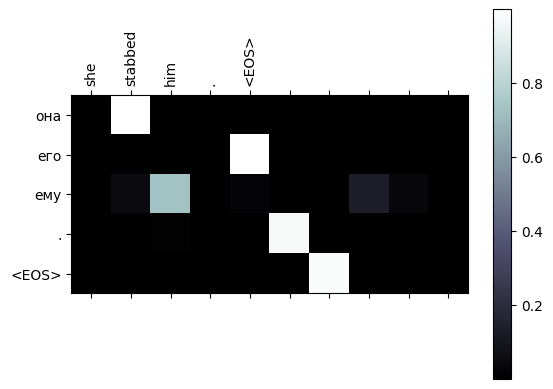

In [69]:
# Эксперименты для моделей с разными типами RNN ячеек (RNN, GRU, LSTM) и кол-вом скрытых состояний
print('Эксперименты с моделями:')
print('----------------------------------------------------------------------')
num_file = 11

rnn_type = nn.GRU
attn_type = 'lection'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=False, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 2000,
           num_file = num_file)



## 5.2. LSTM, attention_type='lection'

LSTM, lection 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

6m 43s (- 60m 32s) (2000 10%) 4.1984 440.3006
13m 37s (- 54m 31s) (4000 20%) 3.8068 236.7074
20m 37s (- 48m 8s) (6000 30%) 3.6357 166.1970
27m 38s (- 41m 27s) (8000 40%) 3.4891 179.6328
34m 43s (- 34m 43s) (10000 50%) 3.3681 213.6508
42m 5s (- 28m 3s) (12000 60%) 3.3314 501.8761
49m 25s (- 21m 10s) (14000 70%) 3.2237 186.6684
57m 1s (- 14m 15s) (16000 80%) 3.1924 178.9517
64m 33s (- 7m 10s) (18000 90%) 3.0743 206.3582
72m 6s (- 0m 0s) (20000 100%) 3.0912 195.2890

evaluation

> i m not afraid of terrorists .
= я не боюсь террористов .
< я не боюсь боюсь . <EOS>

> i m beginning to lose patience with tom .
= я начинаю терять с томом терпение .
< я начинаю с с томом . . <EOS>

> i m glad that we won .
= я рад что мы выиграли .
< я рад что мы в . <EOS>

> i m not old enough to do that .
= мне еще рано это делать .
< я не молод чтобы это сделать . <EOS>

> she s worked hard to save up money .
= она упорно трудились чтобы откладывать деньги .
< она привыкла к к говорить . <EOS>

> i m not a

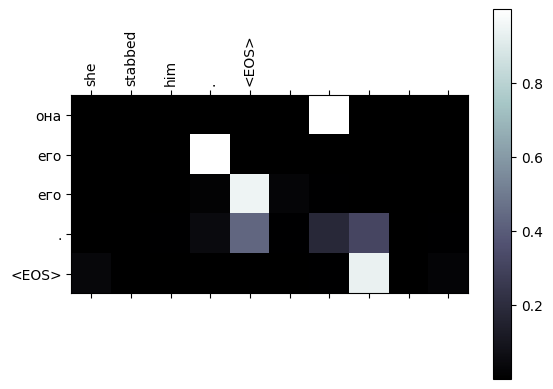

In [70]:
num_file = 12
rnn_type = nn.LSTM
attn_type = 'lection'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=False, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 2000,
           num_file = num_file)

## 5.3. GRU, attention_type='scalar'

GRU, scalar 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

6m 29s (- 58m 28s) (2000 10%) 4.1141 513.2529
13m 39s (- 54m 38s) (4000 20%) 3.6401 218.6441
20m 47s (- 48m 29s) (6000 30%) 3.2886 183.5440
27m 58s (- 41m 58s) (8000 40%) 3.1034 213.3015
35m 9s (- 35m 9s) (10000 50%) 2.8730 146.5617
42m 22s (- 28m 15s) (12000 60%) 2.8363 482.4744
49m 29s (- 21m 12s) (14000 70%) 2.7248 355.8290
56m 43s (- 14m 10s) (16000 80%) 2.7001 204.8540
63m 57s (- 7m 6s) (18000 90%) 2.6322 220.9382
71m 11s (- 0m 0s) (20000 100%) 2.5745 1105.9857

evaluation

> i m sure tom is suffering .
= я уверена что том страдает .
< я уверен что том победит . <EOS>

> i m so glad to see you .
= я так рада вас видеть .
< я так рад тебя видеть . <EOS>

> they re willing to talk about the problem .
= они готовы обсудить проблему .
< они пытаются пытаются проблему . <EOS>

> he s all right .
= у него все в порядке .
< он все . <EOS>

> i m interested in a great many things .
= меня интересует огромное множество вещеи .
< я заинтересован себя чувствую . <EOS>

> i m not done with yo

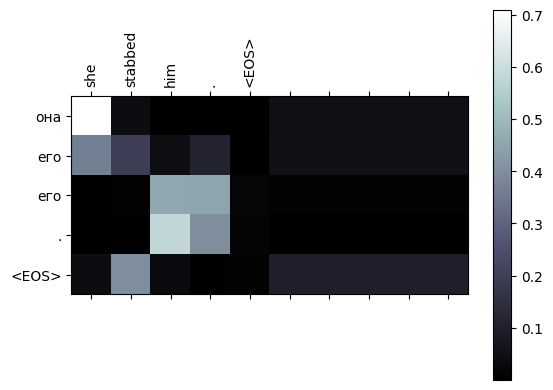

In [71]:
num_file = 13
rnn_type = nn.GRU
attn_type = 'scalar'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=False, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 2000,
           num_file = num_file)

## 5.4. LSTM, attention_type='scalar'

LSTM, scalar 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

7m 8s (- 64m 12s) (2000 10%) 4.1916 465.5778
14m 18s (- 57m 12s) (4000 20%) 3.8824 187.3867
21m 33s (- 50m 19s) (6000 30%) 3.7102 199.7975
28m 45s (- 43m 8s) (8000 40%) 3.5852 167.3285
36m 18s (- 36m 18s) (10000 50%) 3.5112 610.4797
43m 42s (- 29m 8s) (12000 60%) 3.4755 185.4626
50m 54s (- 21m 48s) (14000 70%) 3.3193 174.7194
58m 16s (- 14m 34s) (16000 80%) 3.3404 358.4291
65m 48s (- 7m 18s) (18000 90%) 3.3088 252.4419
73m 18s (- 0m 0s) (20000 100%) 3.3033 584.4112

evaluation

> you re just making things worse .
= вы все только портите .
< ты просто как как и . . <EOS>

> i m going to be a father .
= я буду папои .
< я собираюсь в . . <EOS>

> we re partners .
= мы партнеры .
< мы идем . <EOS>

> you re not invited .
= вы не приглашены .
< ты не не . <EOS>

> she suggested that i cancel the meeting .
= она предложила мне отменить совещание .
< она только на сделать . <EOS>

> i m glad you invited us .
= я рад что вы нас пригласили .
< я рада что ты тебя . . <EOS>

> i m waiting for a 

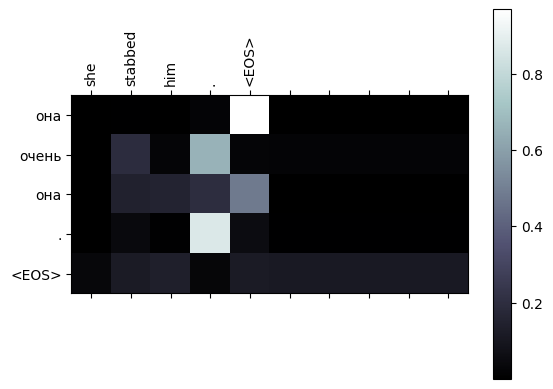

In [75]:
num_file = 14
rnn_type = nn.LSTM
attn_type = 'scalar'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=False, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 2000,
           num_file = num_file)

## 5.5. GRU, attention_type='mlp'

GRU, mlp 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

5m 42s (- 51m 21s) (2000 10%) 4.2579 597.9459
11m 25s (- 45m 43s) (4000 20%) 3.6162 284.5159
17m 16s (- 40m 19s) (6000 30%) 3.3778 239.7215
23m 13s (- 34m 49s) (8000 40%) 3.2063 300.3588
29m 22s (- 29m 22s) (10000 50%) 3.0276 302.0487
35m 35s (- 23m 43s) (12000 60%) 2.9880 1269.1882
41m 50s (- 17m 56s) (14000 70%) 2.8778 310.6420
48m 8s (- 12m 2s) (16000 80%) 2.8355 403.6900
54m 26s (- 6m 2s) (18000 90%) 2.7873 436.3272
60m 49s (- 0m 0s) (20000 100%) 2.7696 924.4072

evaluation

> you aren t my friend .
= ты мне не друг .
< ты мои не подруга . <EOS>

> i m accustomed to this .
= я к этому привычна .
< я привык к . <EOS>

> i m not old .
= я не старыи .
< мне не старыи . <EOS>

> i m sorry i didn t recognize you .
= простите я вас не узнала .
< прости я не не . <EOS>

> you aren t canadian are you ?
= вы же не канадка ?
< ты же же не канадец ? <EOS>

> i m waiting for you to apologize .
= я жду чтобы вы извинились .
< я жду когда жду . <EOS>

> i m adventurous .
= я отважна .
< я страшн

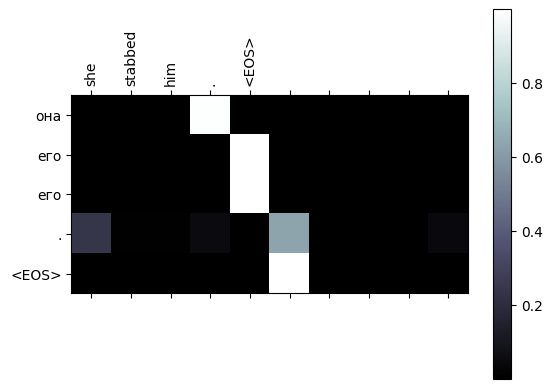

In [72]:
num_file = 15
rnn_type = nn.GRU
attn_type = 'mlp'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=False, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 2000,
           num_file = num_file)

## 5.6. LSTM, attention_type='mlp'

LSTM, mlp 

training


  0%|          | 0/20000 [00:00<?, ?it/s]

6m 41s (- 60m 14s) (2000 10%) 4.2331 479.6904
13m 30s (- 54m 1s) (4000 20%) 3.7904 209.7034
20m 28s (- 47m 46s) (6000 30%) 3.6451 189.9919
27m 44s (- 41m 36s) (8000 40%) 3.4893 205.2258
35m 11s (- 35m 11s) (10000 50%) 3.4119 157.3405
42m 43s (- 28m 29s) (12000 60%) 3.3436 275.4843
50m 16s (- 21m 32s) (14000 70%) 3.2711 233.1922
57m 50s (- 14m 27s) (16000 80%) 3.1840 204.8611
65m 13s (- 7m 14s) (18000 90%) 3.1558 449.1008
72m 53s (- 0m 0s) (20000 100%) 3.1342 328.6764

evaluation

> i m suffering .
= я страдаю .
< я иду . <EOS>

> you re almost as tall as tom is .
= ты почти такои же высокии как том .
< ты почти не такои же как том . <EOS>

> i m waiting for everybody to leave .
= я жду чтобы все ушли .
< я жду жду . . <EOS>

> i m disgusted with tom .
= том мне отвратителен .
< я с томом тома . <EOS>

> he is pleased with his new shoes .
= ему нравятся его новые ботинки .
< он ним на на . . <EOS>

> you re lying to me .
= вы мне врете .
< вы меня меня . <EOS>

> we re buddies .
= мы пр

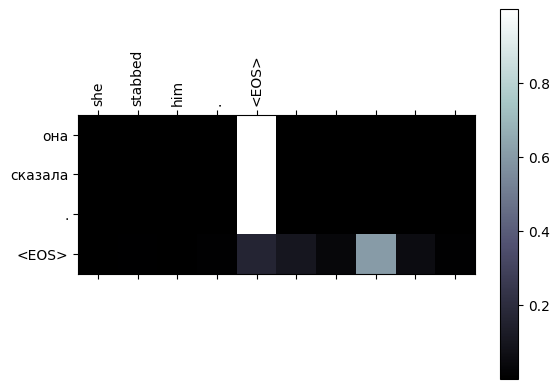

In [73]:
num_file = 16
rnn_type = nn.LSTM
attn_type = 'mlp'
test_model(max_length = MAX_LENGTH,
           learn_rate = 0.0001, prefixes=eng_prefixes, reverse=False, teach_force_ratio = 0.5,
           attn_type=attn_type, num_iters = 20000, every = 2000,
           num_file = num_file)

# 6. Выводы

In [1]:
results = pd.DataFrame(columns=cols)
for i in range(11,17):
  df = pd.read_csv(f'{PATH}{str(i)}.csv', usecols=cols)
  results = pd.concat([results, df], ignore_index=True)
results.drop_duplicates(inplace=True)
results.sort_values(by=['RNN_Type', 'attn_types', 'learning_time'])

NameError: name 'pd' is not defined

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dz9_all_results.csv', sep=';')
df

,RNN_Type,attn_types,Loss,perplexity,learning_time
0,GRU,lection,1.889575,58.424229,59m 11s (- 0m 0s)
1,LSTM,lection,2.140252,25.965012,69m 29s (- 0m 0s)
2,GRU,scalar,1.890593,20.567376,61m 10s (- 0m 0s)
3,LSTM,scalar,2.197992,50.897851,71m 34s (- 0m 0s)
4,GRU,mlp,1.916684,25.078073,60m 42s (- 0m 0s)
5,LSTM,mlp,2.179458,40.906241,73m 41s (- 0m 0s)


В целом, за указанное количество итераций (20000) ни одна из моделей хорошо не обучилась, величина потерь достаточно значительна и перплексия далека от 1.
Данные по обучению 5 первых моделей приведены по  [ссылке](https://github.com/solobala/DLL30/blob/main/DLL30_DZ9.ipynb)

Если судить по величине Loss, то наилучшие результаты при обучении на выбранном датасете при прочих равных условиях показали модель с ячейкой RNN типа GRU. У них  лучшая перплексия, и время обучения меньше чем у lSTM.

Если же сравнивать по типу функции внимания, то можно заметить, что ее выбор влияет на показатели качества модели.
ДЛя LSTM ячеек лучшим выриантом оказалась функция внимания из лекции (минимальная перплексия, минимальные потери, наименьшее время обучения).

Для GRU ячеек лучшие показатели оказались при использовании mlp (Loss 1.8831? перплексия 20.0260 - см файл из гитхаба), хотя за последние итерации они и ухудшились.
